# Run full Granual Predictions

What needs to happen:
- ~~function to temporally and spatially interpolate MERRA2~~
- ~~function to read MERRA2 with interpolation~~
  - PS = surface_pressure
  - T10M = 10-meter_air_temperature (Andy will investigate)
  - TO3 = total_column_ozone
  - TQV = total_precipitable_water_vapor
- ~~function to read VNP02MOD~~
  - in group "observation_data"
    - M14 (for center wavelengths at 8500 nm)
    - M15 (for center wavelengths at 10800 nm)
    - M16 (for center wavelengths at 12000 nm)
- ~~function to read VNP03MOD~~
  - in group "geolocation_data"
    - sensor_azimuth
    - sensor_zenith
    - solar_azimuth
    - solar_zenith
- combine above for model inputs
- check if there are any transformations that need to be made on the inputs before sening them though the model
- load the saved model (see tensorflow.keras.models.load_model as in evaluate.ipynb)
- call the saved model's "predict" method on the combined inputs

## Setup

In [18]:
from pathlib import Path

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from hot_dust import preprocess, DATADIR

In [40]:
open_vnp02 = xr.open_dataset(
    "data/granules/VNP02MOD.A2020168.1448.002.2021127084950.nc",
    group="observation_data",
    mask_and_scale=False,
)

# Access the relavant variables
vnp02_variables = open_vnp02[
    [
        "M14",
        "M14_brightness_temperature_lut",
        "M15",
        "M15_brightness_temperature_lut",
        "M16",
        "M16_brightness_temperature_lut",
    ]
]

# call xr where and fill values less than oe equal to 65527 
vnp02_variables =  xr.where(vnp02_variables >= 65527, np.nan, vnp02_variables) #TODO stack, drop nan (drop same indices from others), convert to int, unstack  

# Create a mask for the NaN values and fill them   
nan_mask = xr.where(np.isnan(vnp02_variables), True, False)
vnp02_variables = vnp02_variables.where(~nan_mask, other=-999.99)

vnp02_variables

# xr stack and unstack 3D to 2D

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float64 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float64 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float64 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...

In [20]:
open_vnp03 = xr.open_dataset(
    "data/granules/VNP03MOD.A2020168.1448.002.2021125194020.nc",
    group="geolocation_data",
)

# Access the relavant variables
vnp03_variables = open_vnp03[
    ["sensor_azimuth", "sensor_zenith", "solar_azimuth", "solar_zenith"]
]

In [41]:
# Merge the model imputs
vnp02_vnp03 = xr.merge([vnp02_variables, vnp03_variables])

# Stack the model inputs (did this in the blocks of code for merra)
vnp02_vnp03.stack(stack_dim=('number_of_lines', 'number_of_pixels'))


# Drop the NaN values (didn't work)
#vnp02_vnp03 = vnp02_vnp03.dropna(dim= 'number_of_lines') 
#vnp02_vnp03 = vnp02_vnp03.dropna(dim= 'number_of_pixels') 

# Convert temperature variables to integers
vnp02_vnp03["M14"] = vnp02_vnp03["M14"].astype(int)
vnp02_vnp03["M15"] = vnp02_vnp03["M15"].astype(int)
vnp02_vnp03["M16"] = vnp02_vnp03["M16"].astype(int)

# Multiply them within the xarray 
vnp02_vnp03["M14"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M14"]]
vnp02_vnp03["M15"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M15"]]
vnp02_vnp03["M16"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M16"]]  

vnp02_vnp03

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float32 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float32 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float32 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    sensor_azimuth                  (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith                   (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth                   (number_of_lines, number_of_pixels) float32 ...
    solar_zenith                    (number_of_lines, number_of_pixels) float32 ...

In [22]:
# Access the relavant variables
M14_ds = vnp02_vnp03["M14"]  # thermal infared wave length
M14_BTL_ds = vnp02_vnp03["M14_brightness_temperature_lut"]
M15_ds = vnp02_vnp03["M15"]  # thermal infared wave length
M15_BTL_ds = vnp02_vnp03["M15_brightness_temperature_lut"]
M16_ds = vnp02_vnp03["M16"]  # thermal infared wave length
M16_BTL_ds = vnp02_vnp03["M16_brightness_temperature_lut"]

# Convert to brightness temperature in K
M14_scaled = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M14"]]
valid_min = vnp02_vnp03["M14_brightness_temperature_lut"].attrs["valid_min"]
valid_max = vnp02_vnp03["M14_brightness_temperature_lut"].attrs["valid_max"]
M14_scaled = M14_scaled.where((M14_scaled <= valid_max) & (M14_scaled >= valid_min))

M15_scaled = vnp02_vnp03["M15_brightness_temperature_lut"][vnp02_vnp03["M15"]]
valid_min = vnp02_vnp03["M15_brightness_temperature_lut"].attrs["valid_min"]
valid_max = vnp02_vnp03["M15_brightness_temperature_lut"].attrs["valid_max"]
M15_scaled = M15_scaled.where((M15_scaled <= valid_max) & (M15_scaled >= valid_min))

M16_scaled = vnp02_vnp03["M16_brightness_temperature_lut"][vnp02_vnp03["M16"]]
valid_min = vnp02_vnp03["M16_brightness_temperature_lut"].attrs["valid_min"]
valid_max = vnp02_vnp03["M16_brightness_temperature_lut"].attrs["valid_max"]
M16_scaled = M16_scaled.where((M16_scaled <= valid_max) & (M16_scaled >= valid_min))

TypeError: invalid indexer array, does not have integer dtype: array([[354.04446, 354.04446, 354.04446, ..., 354.04446, 354.04446,
        354.04446],
       [354.04446, 354.04446, 354.04446, ..., 354.04446, 354.04446,
        354.04446],
       [281.92316, 285.3481 , 287.43567, ..., 279.807  , 279.65118,
        278.91074],
       ...,
       [246.95638, 244.56097, 239.96236, ..., 284.6579 , 284.72696,
        284.76266],
       [354.04446, 354.04446, 354.04446, ..., 354.04446, 354.04446,
        354.04446],
       [354.04446, 354.04446, 354.04446, ..., 354.04446, 354.04446,
        354.04446]], dtype=float32)

## Extract MERRA-2 Input Variables



In [42]:
(DATADIR / 'merra').exists() 
directory_path = (DATADIR / 'merra').glob('*.nc')  
list(directory_path)

[WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020168.1448.002.2021125194020.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020169.0318.002.2021125194543.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020169.1430.002.2021125195004.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020170.0300.002.2021125195511.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020170.1412.002.2021125200321.nc')]

In [43]:
# Merge all the merra files 
directory_path = (DATADIR / 'merra'/ 'VNP03MOD.A2020168.1448.002.2021125194020.nc')
merra_variables = xr.open_dataset(directory_path) 
merra_variables = merra_variables.drop(['time', 'lon', 'lat']) # Drop the coordinates 

# Divide the MERRA2 pressure by 100 to get it in the right units
merra_variables['PS'] = merra_variables['PS']/100 

merra_variables

<xarray.Dataset>
Dimensions:  (number_of_lines: 3232, number_of_pixels: 3200)
Dimensions without coordinates: number_of_lines, number_of_pixels
Data variables:
    PS       (number_of_lines, number_of_pixels) float64 965.8 ... 1.024e+03
    TS       (number_of_lines, number_of_pixels) float64 ...
    TO3      (number_of_lines, number_of_pixels) float64 ...
    TQV      (number_of_lines, number_of_pixels) float64 ...

In [44]:
# xr stack number of lines and pixels vnp03 and vnp02 make it 1D using the stack function
variables_merged = xr.merge([vnp02_vnp03, merra_variables], compat='override') # Merge 1st, then stack
variables_stacked = variables_merged.stack(dims_stacked = ('number_of_lines', 'number_of_pixels'))
variables_stacked

<xarray.Dataset>
Dimensions:                         (dims_stacked: 10342400,
                                     number_of_LUT_values: 65536)
Coordinates:
  * dims_stacked                    (dims_stacked) object MultiIndex
  * number_of_lines                 (dims_stacked) int64 0 0 0 ... 3231 3231
  * number_of_pixels                (dims_stacked) int64 0 1 2 ... 3198 3199
Dimensions without coordinates: number_of_LUT_values
Data variables: (12/14)
    M14                             (dims_stacked) float32 354.0 354.0 ... 354.0
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (dims_stacked) float32 354.0 354.0 ... 354.0
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (dims_stacked) float32 354.0 354.0 ... 354.0
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    ...                              ...
    solar_azimuth                   (dims_stacked) float32 -63.71 ... -167.4
    solar_zenith                    (dims_stacked) float32 34.4 34.39 ... 3.32
    PS                              (dims_stacked) float64 965.8 ... 1.024e+03
    TS                              (dims_stacked) float64 305.7 305.7 ... 298.2
    TO3                             (dims_stacked) float64 280.1 280.1 ... 297.6
    TQV                             (dims_stacked) float64 41.32 41.34 ... 32.62

## 2D Plot of Input Variables

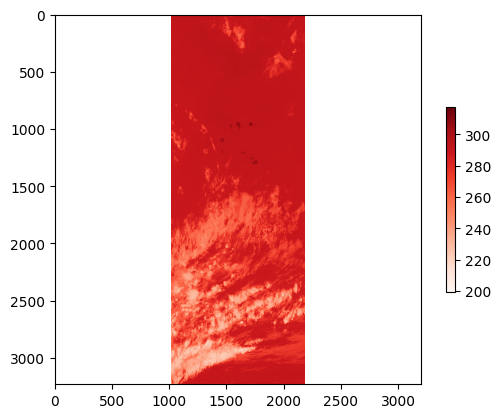

In [51]:
# M14 Map (red)
plt.imshow(M14_scaled, cmap="Reds")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()  

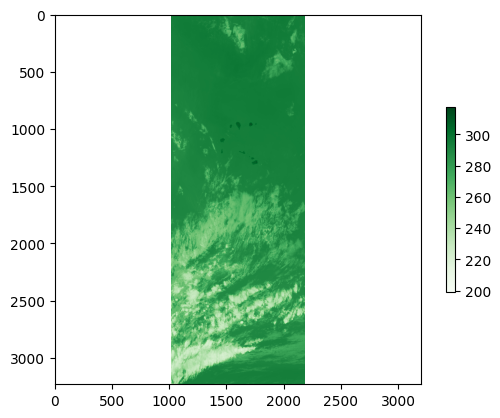

In [52]:
# M15 Map (green)
plt.imshow(M15_scaled, cmap="Greens")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

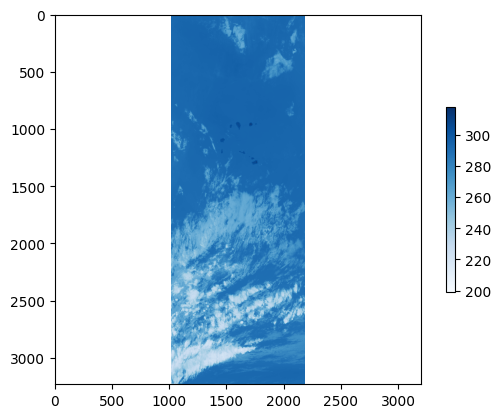

In [53]:
# M16 Map (blue)
plt.imshow(M16_scaled, cmap="Blues")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

## 2D Plot of Predicted Dust Optical Thickness

## WIP / Scratch

In [48]:
xr.open_dataset("data/rt_nn_irdust_training_data.nc")

<xarray.Dataset>
Dimensions:                 (npoints: 250000, nbands_viirs: 3)
Coordinates:
  * nbands_viirs            (nbands_viirs) float32 8.5e+03 1.08e+04 1.2e+04
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle      (npoints) float32 ...
    viewing_zenith_angle    (npoints) float32 ...
    relative_azimuth_angle  (npoints) float32 ...
    viirs_bts               (nbands_viirs, npoints) float32 ...
    dust_optical_thickness  (npoints) float32 ...
    dust_central_height     (npoints) float32 ...
    spress                  (npoints) float32 ...
    h2o                     (npoints) float32 ...
    o3                      (npoints) float32 ...
    ws                      (npoints) float32 ...
    ts                      (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 20230803
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [49]:
xr.open_dataset("data/granules/GMAO_MERRA2.20200616T140000.MET.nc")

<xarray.Dataset>
Dimensions:   (lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    PS        (lat, lon) float32 ...
    QV10M     (lat, lon) float32 ...
    SLP       (lat, lon) float32 ...
    T10M      (lat, lon) float32 ...
    TO3       (lat, lon) float32 ...
    TQV       (lat, lon) float32 ...
    U10M      (lat, lon) float32 ...
    V10M      (lat, lon) float32 ...
    FRSNO     (lat, lon) float32 ...
    FRSEAICE  (lat, lon) float32 ...
Attributes: (12/39)
    date_created:                      2022-03-02T06:13:36Z
    title:                             GMAO MERRA2 2D Hourly,  Instantaneous,...
    product_name:                      GMAO_MERRA2.20200616T140000.MET.nc
    history:                           gmao_met_merge -asm MERRA2_400.inst1_2...
    time_coverage_start:               2020-06-16T14:00:00Z
    time_coverage_end:                 2020-06-16T14:00:00Z
    ...                                ...
    identifier_product_doi:            10.5067/3Z173KIE2TPD;10.5067/RKPHT8KC1...
    processing_level:                  L4
    cdm_data_type:                     grid
    spatialResolution:                 0.5x0.625 degrees
    source:                            MERRA2_400.inst1_2d_asm_Nx.20200616.nc...
    comment:                           This file contains a subset of variabl...

True Color Map

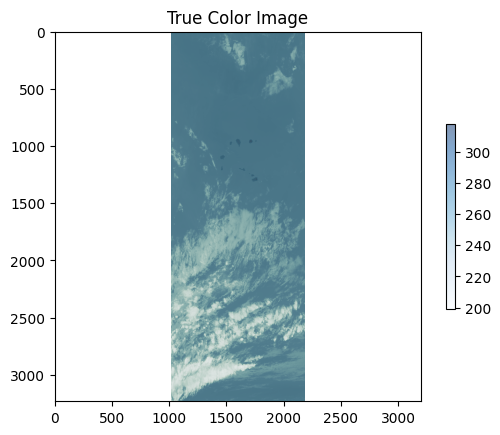

In [55]:
# Overlaying M14 (Red), M15 (Green), and M16 (Blue)
plt.imshow(M14_scaled, cmap="Reds", alpha=0.5)
plt.imshow(M15_scaled, cmap="Greens", alpha=0.5)
plt.imshow(M16_scaled, cmap="Blues", alpha=0.5)

# Colorbar and labels
cb = plt.colorbar(shrink=0.5)
plt.title('True Color Image')

# Show the plot
plt.show()